In [27]:
import pandas as pd
import numpy as np
from scipy.signal import medfilt
from pykalman import KalmanFilter
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

filename = "move_s_11.5"
folder = "cart_movements_datasets"
df = pd.read_csv(f"datasets/{folder}/{filename}.csv")  # e.g. half_theta_1.csv

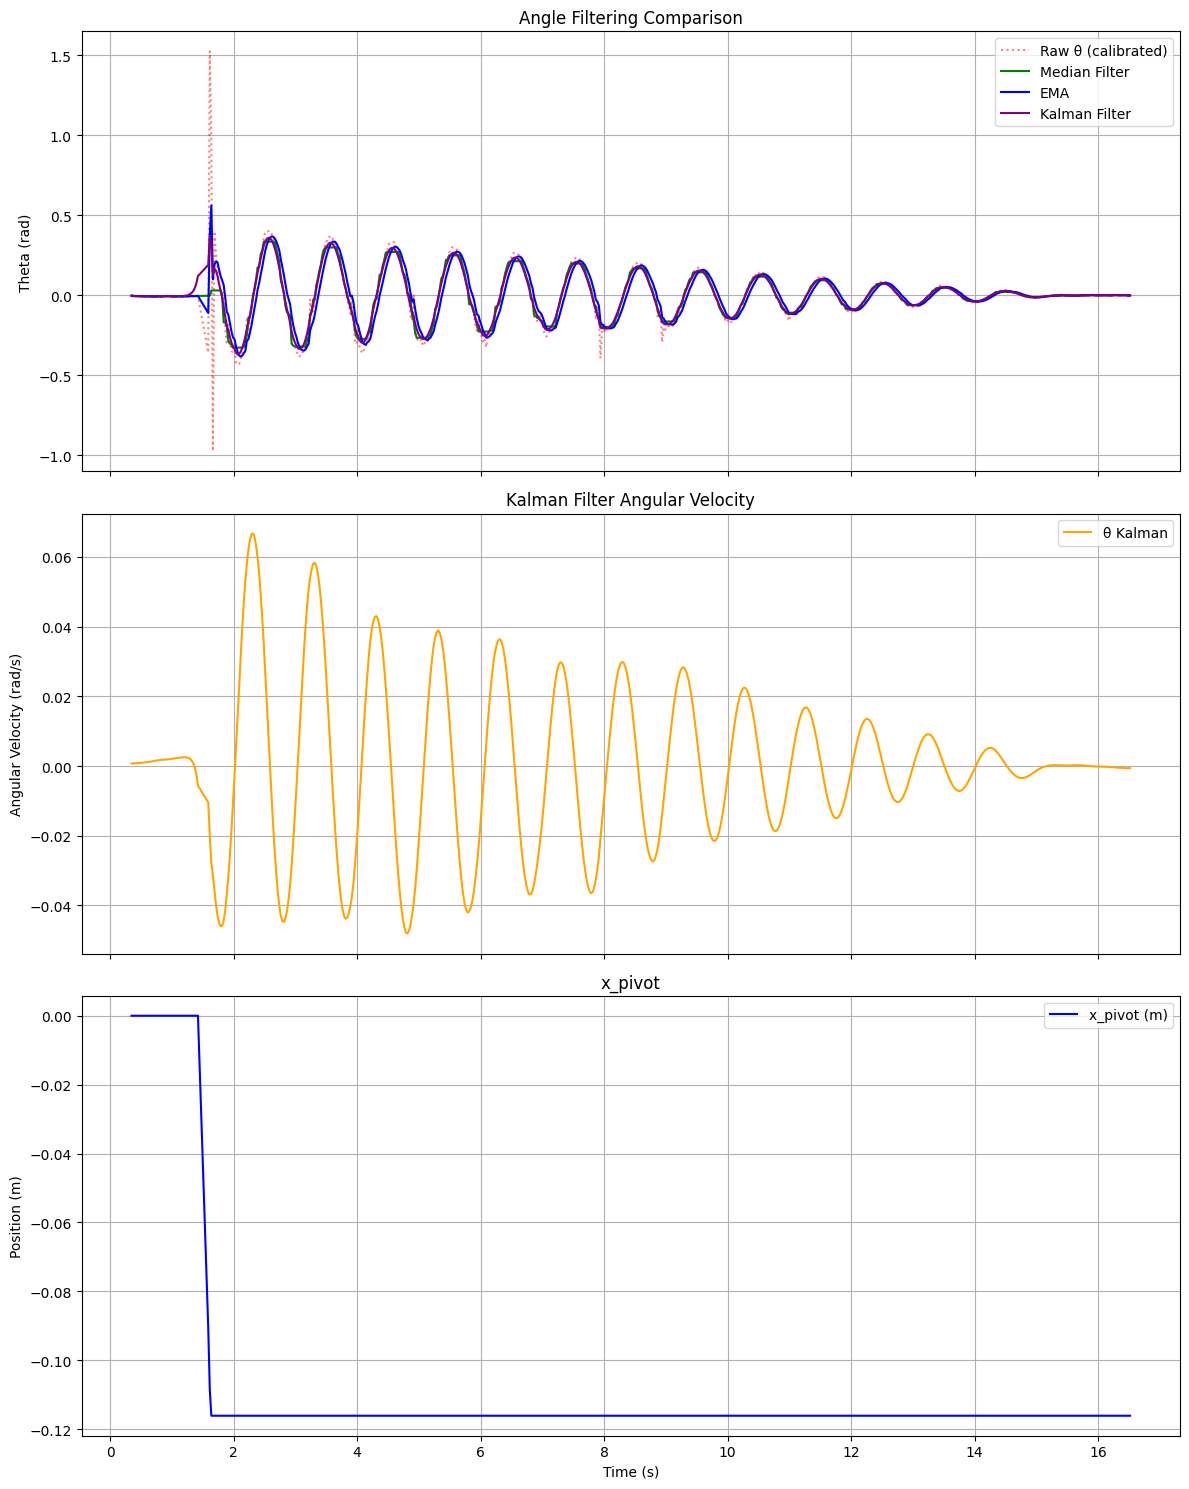

MSE - Median: 0.007913
MSE - EMA: 0.007356
MSE - Kalman: 0.005956
✅ Kalman output saved to: kalman_output.csv


In [28]:

df['time_sec'] = df['time'] / 1_000_000  # Convert microseconds to seconds

df = df.sort_values(by='time_sec').reset_index(drop=True)

# === Convert encoder ticks to meters (using calibration 0.001276 m/tick)
tick_to_m = 0.001276
df['x_pivot_m'] = df['newPosition'] * tick_to_m * -1

df['dt'] = df['time_sec'].diff().fillna(0)


# Step 2: Compute theta from IMU (in radians)
df['theta_raw'] = np.arctan2(df['xAccl'], df['zAccl'])

# Step 3: Calibrate so resting (6 o'clock) = 0°
theta_at_rest = df.tail(50)['theta_raw'].mean()  # assumes end of dataset is stationary
df['theta_calib'] = df['theta_raw'] - theta_at_rest

# Step 4: Optional filtering (just for comparison)
df['theta_med'] = medfilt(df['theta_calib'], kernel_size=15)

df['theta_ema'] = df['theta_calib'].ewm(alpha=0.3, adjust=False).mean()

# Step 5: Kalman Filter (angle + angular velocity)
dt_mean = df['dt'].mean()

kf = KalmanFilter(
    transition_matrices=[[1, dt_mean], [0, 1]],
    observation_matrices=[[1, 0]],
    initial_state_mean=[df['theta_calib'].iloc[0], 0],
    transition_covariance=np.diag([2e-3, 2e-3]),
    observation_covariance=np.array([[0.01]])
)

filtered_state_means, _ = kf.smooth(df['theta_calib'].values)
df['theta_kalman'] = filtered_state_means[:, 0]
df['theta_dot_kalman'] = filtered_state_means[:, 1]

# Step 6: Plot theta, angular velocity, and x_pivot
fig, axs = plt.subplots(3, 1, figsize=(12, 15), sharex=True)

# θ angle plot
axs[0].plot(df['time_sec'], df['theta_calib'], label='Raw θ (calibrated)', color='red', linestyle='dotted', alpha=0.5)
axs[0].plot(df['time_sec'], df['theta_med'], label='Median Filter', color='green')
axs[0].plot(df['time_sec'], df['theta_ema'], label='EMA', color='blue')
axs[0].plot(df['time_sec'], df['theta_kalman'], label='Kalman Filter', color='purple')
axs[0].set_ylabel("Theta (rad)")
axs[0].set_title("Angle Filtering Comparison")
axs[0].legend()
axs[0].grid(True)

# θ̇ angular velocity plot
axs[1].plot(df['time_sec'], df['theta_dot_kalman'], label='θ̇ Kalman', color='orange')
axs[1].set_ylabel("Angular Velocity (rad/s)")
axs[1].set_title("Kalman Filter Angular Velocity")
axs[1].legend()
axs[1].grid(True)

# x_pivot plot
axs[2].plot(df['time_sec'], df['x_pivot_m'], label='x_pivot (m)', color='blue')
axs[2].set_xlabel("Time (s)")
axs[2].set_ylabel("Position (m)")
axs[2].set_title("x_pivot")
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

# Step 7: Error metrics (if needed)
mse_median = mean_squared_error(df['theta_calib'], df['theta_med'])
mse_ema = mean_squared_error(df['theta_calib'], df['theta_ema'])
mse_kalman = mean_squared_error(df['theta_calib'], df['theta_kalman'])

print(f"MSE - Median: {mse_median:.6f}")
print(f"MSE - EMA: {mse_ema:.6f}")
print(f"MSE - Kalman: {mse_kalman:.6f}")

# Step 8: Save Kalman output to CSV
df_out = df[['time_sec', 'theta_kalman', 'theta_dot_kalman', 'x_pivot_m']]
df_out.to_csv(f"datasets/filtered_datasets/{filename}_kalman_output.csv", index=False)
print("✅ Kalman output saved to: kalman_output.csv")